In [2]:
import sys
sys.path.insert(0, '..') 
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import math
relu = torch.nn.ReLU()

from src.modular_rnn import ModRNN, RingModule

/Users/alexnegron/miniconda3/envs/torch/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448801785/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_style("white")
mpl.rcParams['axes.grid']  = True
mpl.rcParams['axes.grid.which']  = 'both'
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['ytick.minor.visible']  = True
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = '0.8'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = (6, 3)
mpl.rcParams['figure.titlesize'] = 30
mpl.rcParams['font.size'] = 27.5
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.dpi'] = 125

In [4]:
plt.rcParams.update(plt.rcParamsDefault)


# Integration task dataset functions

## Generator

In [5]:
class BinaryTrajectoryGenerator:
    def __init__(self, num_timesteps=2000, dt=0.5, flip_rate=0.01, omega_value=0.5, target_type='pos', **kwargs):
        self.num_timesteps = num_timesteps
        self.dt = dt
        self.flip_rate = flip_rate
        self.omega_value = omega_value
        self.target_type = target_type
        self.kwargs = kwargs

    def generate_binary_omega(self):
        omegas =  self.omega_value * np.ones(self.num_timesteps)
        initial_direction = np.random.choice([-1, 1])

        # Generate flip times following an exponential distribution: E[num_flips] = flip_rate * num_timesteps
        flip_times = np.cumsum(np.random.exponential(scale=1/self.flip_rate, size=self.num_timesteps))
        flip_times = flip_times[flip_times < self.num_timesteps].astype(int) 
        
        omegas[:flip_times[0]] *= initial_direction # flip initial direction negative (sometimes)

        flip_index = 1
        for t in range(flip_times[0], self.num_timesteps):
            if flip_index < len(flip_times) and t == flip_times[flip_index]:
                omegas[t:] *= -1
                flip_index += 1

        return omegas

    def generate_trajectory(self):
        omegas = self.generate_binary_omega()
        theta0 = 0
        theta = theta0
        inputs = np.zeros((self.num_timesteps, 1))
        targets = np.zeros((self.num_timesteps, 2 if self.target_type == 'pos' else 1))
        
        # integration of angular velocity to get angle
        for j in range(self.num_timesteps):
            omega = omegas[j]
            k1 = omega * self.dt
            k2 = (omega + 0.5 * k1) * self.dt
            k3 = (omega + 0.5 * k2) * self.dt
            k4 = (omega + k3) * self.dt
            dtheta = (k1 + 2 * k2 + 2 * k3 + k4) / 6
            theta = (theta + dtheta) % (2 * np.pi)

            inputs[j, 0] = omega 

            if self.target_type == 'pos':
                targets[j, 0] = np.cos(theta)
                targets[j, 1] = np.sin(theta)
            elif self.target_type == 'angle':
                targets[j,0] = theta
            
        return inputs, targets
    
def generate_dataset(num_timesteps, num_trajectories, batch_size=64, **kwargs):
    generator = BinaryTrajectoryGenerator(num_timesteps, **kwargs)

    target_shape_modifier = 2 if generator.target_type == 'pos' else 1

    inputs = np.zeros((batch_size, num_timesteps, 1 * num_trajectories))
    targets = np.zeros((batch_size, num_timesteps, target_shape_modifier * num_trajectories))
    
    for i in range(batch_size):
        for j in range(num_trajectories):
            inputs_single, targets_single = generator.generate_trajectory()
            inputs[i, :, 1*j:1*(j+1)] = inputs_single
            targets[i, :, target_shape_modifier*j:target_shape_modifier*(j+1)] = targets_single

    return inputs, targets

## Test

(10, 1000, 1) (10, 1000, 1)


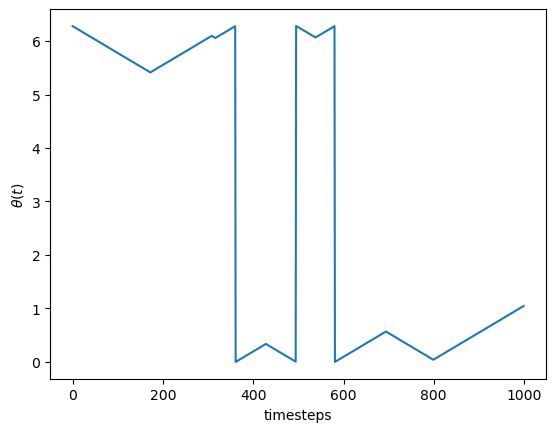

In [6]:
num_samples = 1
num_trajectories = 1
num_timesteps = 1000
flip_rate = 1e-2
# omega_process = 'constant'
omega_process = 'binary'
omega_value = 0.5
dt = .01

# generate one batch of training data
inputs, targets = generate_dataset(num_timesteps,
                                   num_trajectories,
                                   dt=0.01,
                                   flip_rate=1e-2,
                                   omega_value=0.5,
                                   target_type='angle',
                                   batch_size=10
                                   )
print(inputs.shape, targets.shape)
plt.plot(targets[0,...])
plt.xlabel('timesteps')
plt.ylabel(r'$\theta(t)$')
plt.show()

# Training vanilla RNN

- for a fixed batch of size $n$, and a sample $i$ in this batch, $\theta^{(i)}(t) \in [0, 2\pi)^d$ is a $d$-dimensional vector of angles at time $t \in [T]$ (note that 0 and $2\pi$ are identified)
- sample index $i \in [B]$ runs over indices up to batch size $B$
- time index $t \in [T]$ runs over indices up to sequence length $T$ (timesteps)
- let $\hat{\theta}^{(i)}(t)$ be the predicted angles at time $t$ for sample $i$

At each time point $t$, we compute the loss $\ell(\hat{\theta}^{(i)}(t), \theta^{(i)}(t))$ between the predicted angles and the target angles for each sample $i \in [n]$, then averaged over time the total loss defined with an angular analogue of the mean-square loss:
$$ 
\mathcal{L}_\beta(\theta^{(i)}, \hat{\theta}^{(i)}) = \frac{1}{T} \sum_{t=1}^T (2  - 2\cos(\theta^{(i)}(t) - \hat{\theta}^{(i)}(t)))^{1/\beta}.
$$
Parameter $\beta$ controls the sensitivity to large errors. For $\beta=2$, the loss is the square of the Euclidean distance between the angles. Smaller values of $\beta$ give more importance to large errors. See [this post](https://stats.stackexchange.com/questions/425234/loss-function-and-encoding-for-angles) for discussion and connections to MLE with von Mises distributions.

In [7]:
class CircularMSELoss(nn.Module):
    def __init__(self, beta=2):
        super(CircularMSELoss, self).__init__()
        self.beta = beta

    def forward(self, y_pred, y_true):
        loss =  torch.mean( (2 * (1.0 - torch.cos(y_true - y_pred))) ** (1/self.beta) )
        return loss

Let's try training a vanilla RNN on the integration task with angular representation and angular losses.

In [8]:
def compute_validation_loss(net, num_timesteps=2000, batch_size=16, beta=2, device='cpu'):
    with torch.no_grad():
        val_losses = []
        criterion = CircularMSELoss(beta=beta)

        val_input, val_target = generate_dataset(
                num_timesteps,       
                num_trajectories,    
                dt=0.01,
                flip_rate=1e-2,
                omega_value=0.5,
                target_type='angle',
                batch_size=batch_size
            )
        for i in range(batch_size):
            val_sample_input = torch.Tensor(val_input[i, ...]).to(device)
            val_sample_target = torch.Tensor(val_target[i, ...]).to(device)
            val_sample_output, _ = net(val_sample_input)
            val_sample_output = torch.Tensor(val_sample_output)
            val_sample_loss = criterion(val_sample_output, val_sample_target)
            val_losses.append(val_sample_loss.item())

        avg_loss = sum(val_losses) / batch_size 
        return avg_loss 

device = cpu
Epoch 1/500
Average train loss: 0.91664137465533224169
Validation loss, same T: 1.00332239759409480584
Validation loss, extended T: 1.04374191686790074307


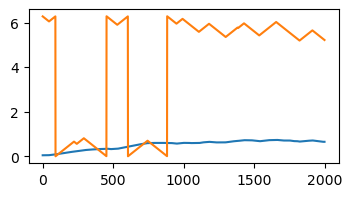

Epoch 2/500
Average train loss: 1.01833616270272919735
Validation loss, same T: 0.92166702995389426789
Validation loss, extended T: 0.96420104736496714537


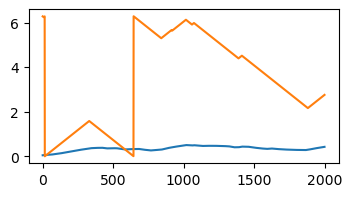

Epoch 3/500
Average train loss: 0.98064254125747662982
Validation loss, same T: 1.01247098279475444826
Validation loss, extended T: 1.02380207354097807482


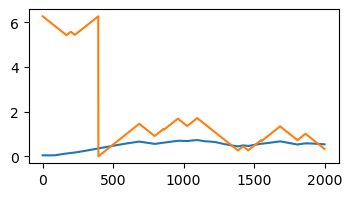

Epoch 4/500
Average train loss: 0.87143999447221454080
Validation loss, same T: 0.99242646355016228554
Validation loss, extended T: 0.98906688911269835529


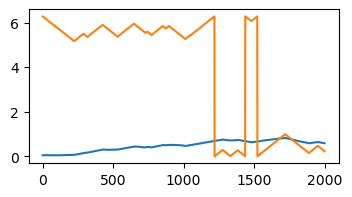

Epoch 5/500
Average train loss: 0.91875622762034003799
Validation loss, same T: 0.98650185312506555313
Validation loss, extended T: 1.04821923215154133580


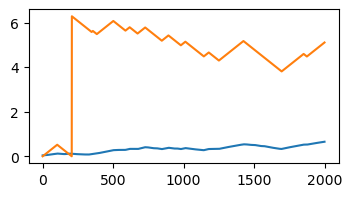

Epoch 6/500
Average train loss: 0.99622835360470696209
Validation loss, same T: 0.92851079451366436146
Validation loss, extended T: 1.03801409560373536500


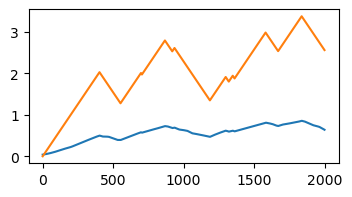

Epoch 7/500
Average train loss: 0.89555601940372475678
Validation loss, same T: 0.88242447348601993351
Validation loss, extended T: 1.01073392821622598525


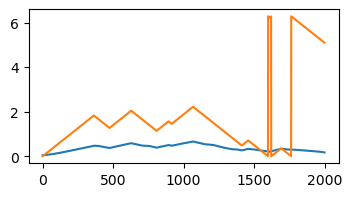

Epoch 8/500
Average train loss: 1.01246257108541959369
Validation loss, same T: 0.96394494020575782756
Validation loss, extended T: 0.91494849012338252958


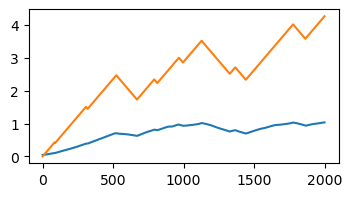

Epoch 9/500
Average train loss: 0.94603202869548919107
Validation loss, same T: 0.96131896142245520931
Validation loss, extended T: 0.99947205738085698190


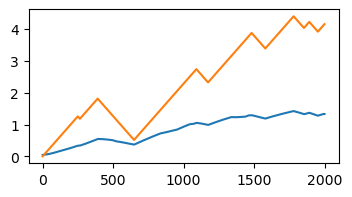

Epoch 10/500
Average train loss: 0.88571630473022322505
Validation loss, same T: 0.90515412624167657096
Validation loss, extended T: 1.02065751022747863708


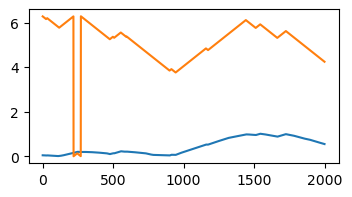

Epoch 11/500
Average train loss: 0.90196457088440795680
Validation loss, same T: 0.97481801062757633680
Validation loss, extended T: 0.98967070110890631440


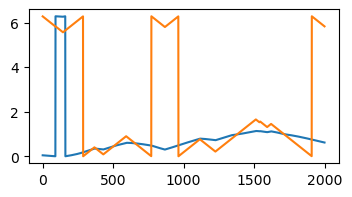

Epoch 12/500
Average train loss: 0.92662729459368686769
Validation loss, same T: 0.77673734793275328592
Validation loss, extended T: 0.92348870223165524518


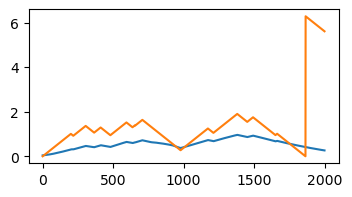

Epoch 13/500
Average train loss: 0.89479451487158234713
Validation loss, same T: 0.83400102646081653024
Validation loss, extended T: 0.93841400479840164639


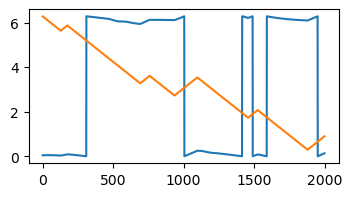

Epoch 14/500
Average train loss: 0.85123235485374093567
Validation loss, same T: 0.87039568314911952562
Validation loss, extended T: 0.96755535802716785554


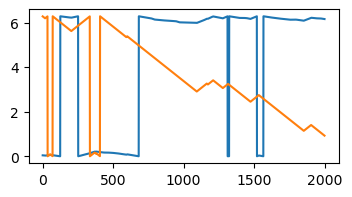

Epoch 15/500
Average train loss: 0.78799328815028157891
Validation loss, same T: 0.89712978262742670843
Validation loss, extended T: 1.01856951031757048121


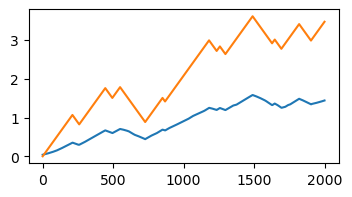

Epoch 16/500
Average train loss: 0.86822704077920864751
Validation loss, same T: 0.82753865383574887193
Validation loss, extended T: 0.93649853318297049398


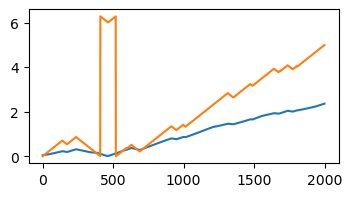

Epoch 17/500
Average train loss: 0.84014834761572310118
Validation loss, same T: 0.78458377356607089670
Validation loss, extended T: 0.97720332480243965456


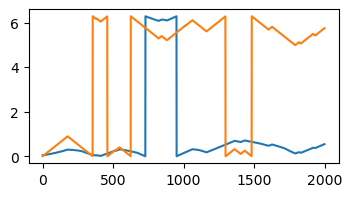

Epoch 18/500
Average train loss: 0.86574193292094869800
Validation loss, same T: 0.82993694458016209481
Validation loss, extended T: 0.87712460985774853839


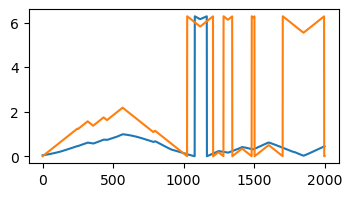

Epoch 19/500
Average train loss: 0.81430603446852178884
Validation loss, same T: 0.83901067036285126299
Validation loss, extended T: 0.91657462369920805756


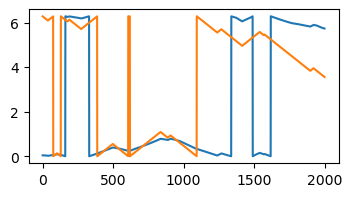

Epoch 20/500
Average train loss: 0.83231560920794211977
Validation loss, same T: 0.80727779571883484522
Validation loss, extended T: 0.87244689513473694387


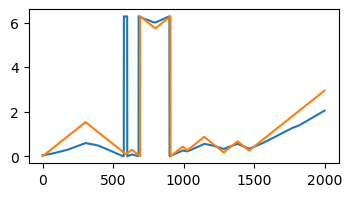

Epoch 21/500
Average train loss: 0.74908468634096225802
Validation loss, same T: 0.69221372075532972001
Validation loss, extended T: 0.81529525242828282394


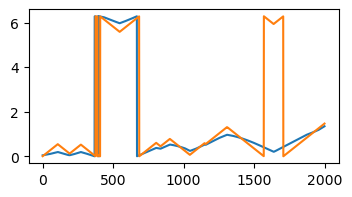

Epoch 22/500
Average train loss: 0.67631217257450637614
Validation loss, same T: 0.65798669143764276779
Validation loss, extended T: 0.72453084359490893540


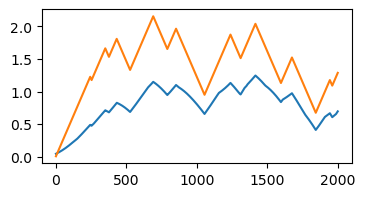

Epoch 23/500
Average train loss: 0.71411871434182272456
Validation loss, same T: 0.74682223870075159500
Validation loss, extended T: 0.68273436682803023690


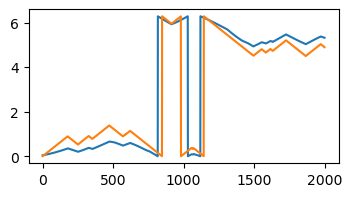

Epoch 24/500
Average train loss: 0.64693998097883220755
Validation loss, same T: 0.71122232299944820877
Validation loss, extended T: 0.76293330105941359331


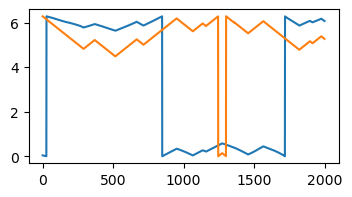

Epoch 25/500
Average train loss: 0.66236868373840640523
Validation loss, same T: 0.62935584281676026919
Validation loss, extended T: 0.74336174731517767889


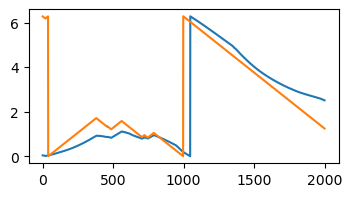

Epoch 26/500
Average train loss: 0.61237869599496430606
Validation loss, same T: 0.63169423671581703683
Validation loss, extended T: 0.65538582977531156804


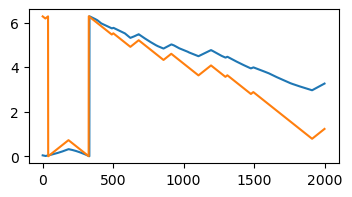

Epoch 27/500
Average train loss: 0.57545201348688446163
Validation loss, same T: 0.61450349892503763893
Validation loss, extended T: 0.67746194961008088242


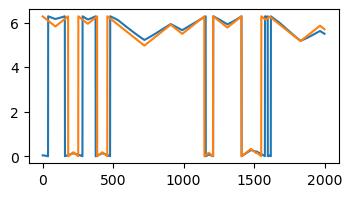

Epoch 28/500
Average train loss: 0.58111985166589530394
Validation loss, same T: 0.66108036068580355860
Validation loss, extended T: 0.65148937205935575356


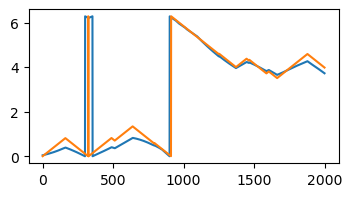

Epoch 29/500
Average train loss: 0.69370696262517972386
Validation loss, same T: 0.64230154043073206527
Validation loss, extended T: 0.70245463239300776070


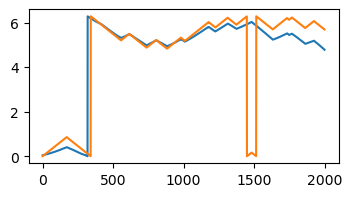

Epoch 30/500
Average train loss: 0.55903269854840631492
Validation loss, same T: 0.61804773498323761771
Validation loss, extended T: 0.68929110876217780657


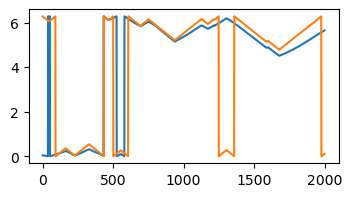

Epoch 31/500
Average train loss: 0.56908489668735273703
Validation loss, same T: 0.55911635288027483615
Validation loss, extended T: 0.67126251447447005116


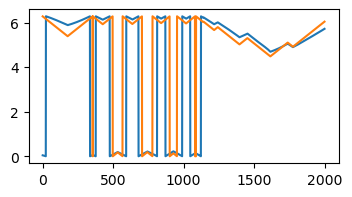

Epoch 32/500
Average train loss: 0.59157819179960935418
Validation loss, same T: 0.52599870169853324420
Validation loss, extended T: 0.59329798909662456730


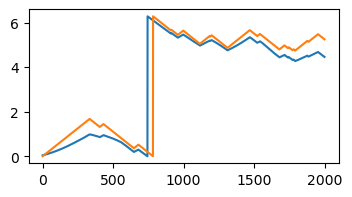

Epoch 33/500
Average train loss: 0.62872966608372959918
Validation loss, same T: 0.51275187703718760890
Validation loss, extended T: 0.63789597057467128938


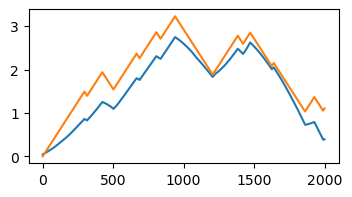

Epoch 34/500
Average train loss: 0.49376897876569741941
Validation loss, same T: 0.51092787728682098614
Validation loss, extended T: 0.63248126330750342738


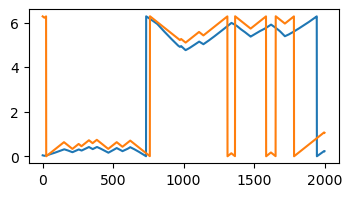

Epoch 35/500
Average train loss: 0.65135702688506125213
Validation loss, same T: 0.50846846376115295563
Validation loss, extended T: 0.58414581240086915770


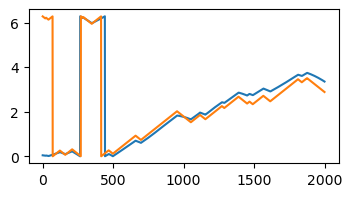

Epoch 36/500
Average train loss: 0.57907303576768598408
Validation loss, same T: 0.47447086440220137549
Validation loss, extended T: 0.65243221746969015662


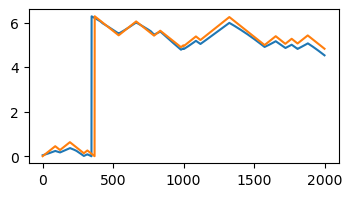

Epoch 37/500
Average train loss: 0.51877041511147092834
Validation loss, same T: 0.53067337759145649656
Validation loss, extended T: 0.56009341825870795351


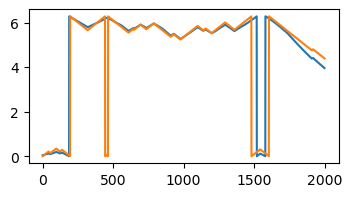

Epoch 38/500
Average train loss: 0.49190118326110121583
Validation loss, same T: 0.49819694821697652065
Validation loss, extended T: 0.58000645825606900186


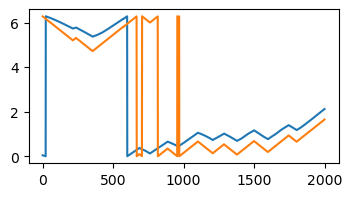

Epoch 39/500
Average train loss: 0.47665917034479521330
Validation loss, same T: 0.50483697117618109296
Validation loss, extended T: 0.63881622925067038654


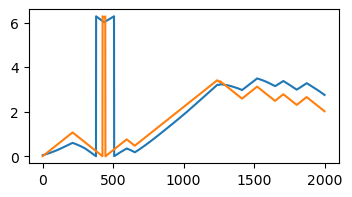

Epoch 40/500
Average train loss: 0.54205031072799902958
Validation loss, same T: 0.49038176714578901594
Validation loss, extended T: 0.57881545900318798203


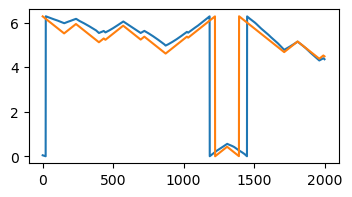

Epoch 41/500
Average train loss: 0.52894343271249411043
Validation loss, same T: 0.47708347691735963902
Validation loss, extended T: 0.57121209200501088521


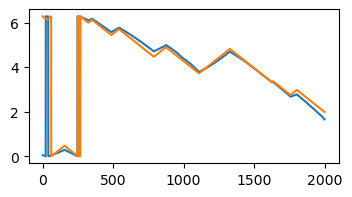

Epoch 42/500
Average train loss: 0.49895891550976900763
Validation loss, same T: 0.42351166760244329801
Validation loss, extended T: 0.56735175592232034436


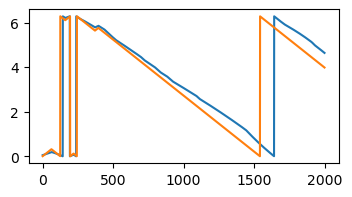

Epoch 43/500
Average train loss: 0.51818239227923601486
Validation loss, same T: 0.48410456270980167792
Validation loss, extended T: 0.52551398159337714411


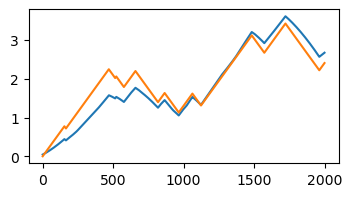

Epoch 44/500
Average train loss: 0.45749784305148349928
Validation loss, same T: 0.48694420867557297594
Validation loss, extended T: 0.49531364965417234991


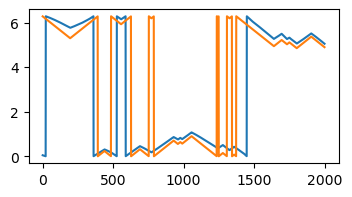

Epoch 45/500
Average train loss: 0.53541303287169339509
Validation loss, same T: 0.50940193079139339805
Validation loss, extended T: 0.43644056107389883614


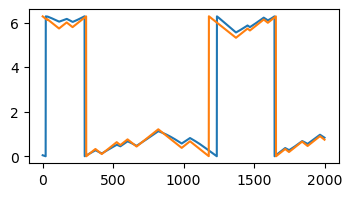

Epoch 46/500
Average train loss: 0.39088419524232720370
Validation loss, same T: 0.36571193287614861545
Validation loss, extended T: 0.46297989485270479859


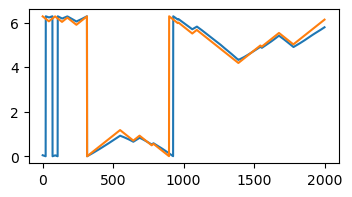

Epoch 47/500
Average train loss: 0.36991143324314640362
Validation loss, same T: 0.36952054734459072183
Validation loss, extended T: 0.45450266756360796494


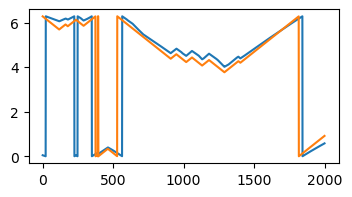

Epoch 48/500
Average train loss: 0.39323727886918241614
Validation loss, same T: 0.35028136644284291190
Validation loss, extended T: 0.46899350205809470227


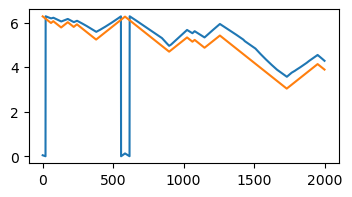

Epoch 49/500
Average train loss: 0.32983250439547701083
Validation loss, same T: 0.34155004894026241846
Validation loss, extended T: 0.38436509106038391215


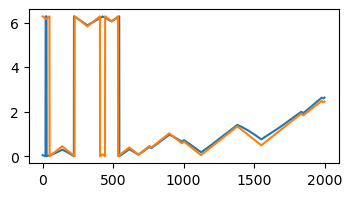

Epoch 50/500
Average train loss: 0.28713836612206955490
Validation loss, same T: 0.26560032064042587985
Validation loss, extended T: 0.30950869200527636460


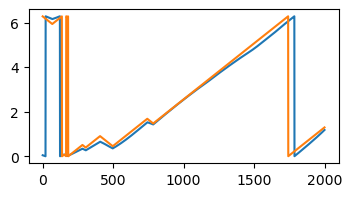

Epoch 51/500
Average train loss: 0.28190917827369427195
Validation loss, same T: 0.23023151373654579532
Validation loss, extended T: 0.37511223788079750552


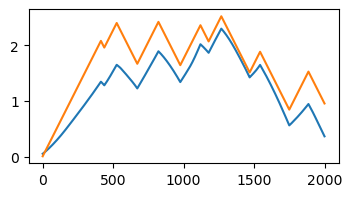

Epoch 52/500
Average train loss: 0.25514416844947923613
Validation loss, same T: 0.28419807450665218740
Validation loss, extended T: 0.33316997247524859915


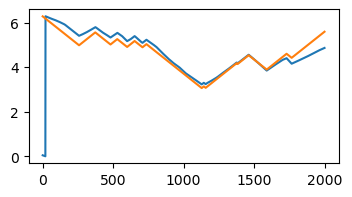

Epoch 53/500
Average train loss: 0.25339036749136090165
Validation loss, same T: 0.26805663111858635261
Validation loss, extended T: 0.31888108054060543273


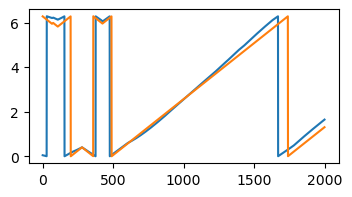

Epoch 54/500
Average train loss: 0.22860647311758169886
Validation loss, same T: 0.24343803023783991413
Validation loss, extended T: 0.25761021420160895579


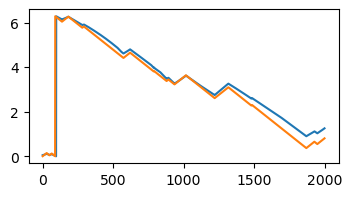

Epoch 55/500
Average train loss: 0.22941485157178326260
Validation loss, same T: 0.20498834129038912000
Validation loss, extended T: 0.26693118007931743163


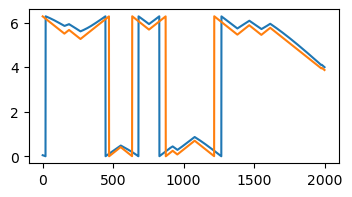

Epoch 56/500
Average train loss: 0.23905526675089727728
Validation loss, same T: 0.19782996057115959099
Validation loss, extended T: 0.24343761097350169464


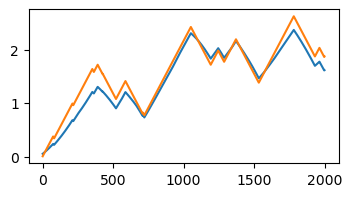

Epoch 57/500
Average train loss: 0.20022946150860071457
Validation loss, same T: 0.22666767496992784592
Validation loss, extended T: 0.23274652020667896402


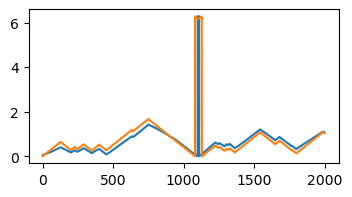

Epoch 58/500
Average train loss: 0.20724748880486623670
Validation loss, same T: 0.20196559521937984538
Validation loss, extended T: 0.23145421247841310719


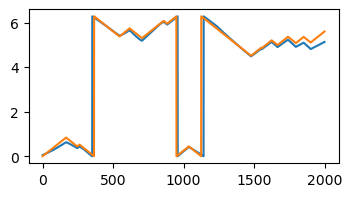

Epoch 59/500
Average train loss: 0.18884037970009201479
Validation loss, same T: 0.18400636177866938614
Validation loss, extended T: 0.26419015464817735550


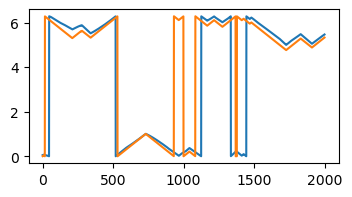

KeyboardInterrupt: 

In [9]:
from src.vanilla_rnn import VanillaRNN

# initialize the network 
torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

num_trajectories = 2
input_size = output_size = num_trajectories 
num_timesteps = 2000

net = VanillaRNN(input_size,
             output_size,
             device=device,
             nNeurons=64,
             dt=.05,
             tau=10.0,
            )

# criterion = torch.nn.MSELoss()
criterion = CircularMSELoss(beta=2)
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
num_epochs = 500
batch_size = 32

losses = []
perfs = []
val_losses_same_T = []
val_losses_extended_T = []


for epoch in range(num_epochs):
    total_loss = 0.0
    
    # randomly generate one batch of training data for this epoch
    batch_inputs, batch_targets = generate_dataset(
                                    num_timesteps,       # timesteps
                                    num_trajectories,    # num_trajectories
                                    dt=0.01,
                                    flip_rate=1e-2,
                                    omega_value=0.5,
                                    target_type='angle',
                                    batch_size=batch_size
                                    )

    # train over this batch
    num_samples = batch_inputs.shape[0]
    for i in range(num_samples):
        sample_input = torch.Tensor(batch_inputs[i, ...]).to(device)
        sample_target = torch.Tensor(batch_targets[i, ...]).to(device)

        sample_output, activity = net(sample_input)
        sample_output = torch.Tensor(sample_output)

        loss = criterion(sample_output, sample_target)

        optimizer.zero_grad()
        loss.backward()
        
        # gradient clipping
        # Compute the norm of the gradients before clipping
        # total_norm_before = 0
        # for p in net.parameters():
        #     param_norm = p.grad.data.norm(2)
        #     total_norm_before += param_norm.item() ** 2
        # total_norm_before = total_norm_before ** (1. / 2)
        # print(f'Gradient norm before clipping: {total_norm_before}')
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=20.0, error_if_nonfinite=True)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_samples
    losses.append(avg_loss)
    percent_complete = ((epoch+1) / num_epochs) * 100
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Average train loss: {avg_loss:.20f}')


    # Evaluate the model on some validation data 
    # same time window length as training data
    val_loss = compute_validation_loss(net, num_timesteps=num_timesteps, batch_size=batch_size, beta=2)
    val_losses_same_T.append(val_loss)
    print(f'Validation loss, same T: {val_loss:.20f}')

    # longer time window 
    val_loss = compute_validation_loss(net, num_timesteps=num_timesteps + 500, batch_size=batch_size, beta=2)
    val_losses_extended_T.append(val_loss)
    print(f'Validation loss, extended T: {val_loss:.20f}')
    
    plt.figure(figsize=(4, 2))
    outputs_mod = np.mod(sample_output.detach().cpu().numpy()[:,0], 2*np.pi)
    plt.plot(outputs_mod, label='Model output')
    plt.plot(sample_target.detach().cpu().numpy()[:,0], label='Target')
    # plt.ylim([0, 2*np.pi])
    # plt.legend()
    plt.show()

    if total_loss/num_samples < 0.001:
        print(f'Training stopped early at epoch {epoch+1} because the average loss fell below 0.05')
        break

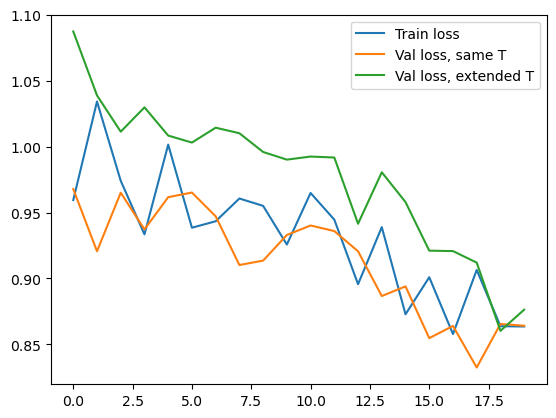

In [44]:
plt.plot(losses, label='Train loss')
plt.plot(val_losses_same_T, label='Val loss, same T')
plt.plot(val_losses_extended_T, label='Val loss, extended T')
plt.legend()
plt.show()

In [63]:
net.CTRNN.recurrent_weights.detach().cpu().numpy()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [1]:
plt.imshow(net.CTRNN.recurrent_weights.detach().cpu().numpy())
plt.colorbar()
plt.show()

NameError: name 'plt' is not defined